# Analysis of YouTube dataset
The goal of this notebook is to create a model for predicting the number of subscribers from channel attributes for large channels (>12 million subscribers).

The idea is to create a classifier that can choose a subscriber count bin for the channel.

In [1]:
import pandas as pd
import numpy as np

dataset = pd.read_csv("./Global YouTube Statistics.csv", encoding="iso-8859-1")

print(dataset)

     rank                    Youtuber  subscribers   video views  \
0       1                    T-Series    245000000  2.280000e+11   
1       2              YouTube Movies    170000000  0.000000e+00   
2       3                     MrBeast    166000000  2.836884e+10   
3       4  Cocomelon - Nursery Rhymes    162000000  1.640000e+11   
4       5                   SET India    159000000  1.480000e+11   
..    ...                         ...          ...           ...   
990   991               Natan por Aï¿     12300000  9.029610e+09   
991   992    Free Fire India Official     12300000  1.674410e+09   
992   993                       Panda     12300000  2.214684e+09   
993   994                 RobTopGames     12300000  3.741235e+08   
994   995                Make Joke Of     12300000  2.129774e+09   

             category                       Title  uploads         Country  \
0               Music                    T-Series    20082           India   
1    Film & Animation      

The first task is to clean up the dataset by only including relevant columns and transform them.
Columns were selected based on accessibility and simplicity.

X: views, category, uploads, country, created_year

Y: subscribers

In [2]:
from sklearn.preprocessing import LabelEncoder

df = dataset

df = df.rename(columns={ "video views": "views", "Abbreviation": "abbr" }) # keep naming scheme consistent (snake_case)
df = df[["subscribers", "views", "category", "uploads", "abbr", "created_year"]]
df = df.dropna()
df = df.loc[df["uploads"] >= 10] # filter out low video count channels (such as auto-generated feeds like YouTube Movies)
df["created_year"] = df["created_year"].astype(int) # make created_year an integer

# add an encoded column for country codes
co_le = LabelEncoder()
df["category"] = co_le.fit_transform(df["category"])

# add an encoded column for categories
cat_le = LabelEncoder()
df["country"] = cat_le.fit_transform(df["abbr"])

df = df.drop("abbr", axis=1) # don't need this anymore, we can get it from the encoder

print(df)

     subscribers         views  category  uploads  created_year  country
0      245000000  2.280000e+11         8    20082          2006       19
2      166000000  2.836884e+10         3      741          2012       42
3      162000000  1.640000e+11         2      966          2006       42
4      159000000  1.480000e+11        14   116536          2006       19
6      112000000  9.324704e+10        11     1111          2015       42
..           ...           ...       ...      ...           ...      ...
989     12400000  6.993406e+09         8       99          2012       42
990     12300000  9.029610e+09        15     1200          2017        5
991     12300000  1.674410e+09        11     1500          2018       19
993     12300000  3.741235e+08         5       39          2012       36
994     12300000  2.129774e+09         1       62          2017       19

[800 rows x 6 columns]


Next, we need to perform discretization and place the subscriber count into bins.

Since we are using few features which represent where only three are continuous (and one of those has low variation), any precise answer won't be accurate.
Instead, opting to put the count of subscribers into bins (e.g. 10M, 100M, 500M, 1B, 1.5B, 2B, etc.) will give a more accurate answer, at the cost of precision.

Before deciding whether to have equal or variable width bins, let's look at the distribution of the subscriber count.

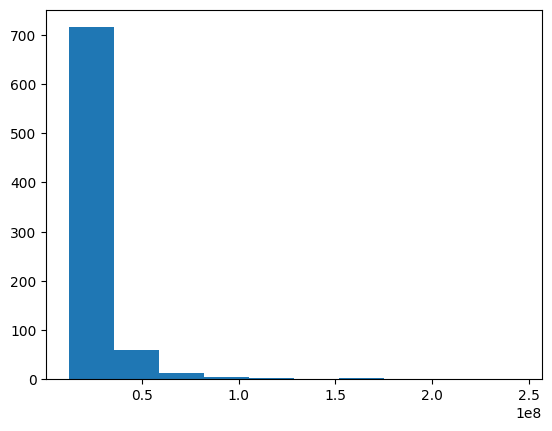

In [3]:
import matplotlib.pyplot as plt

plt.hist(df["subscribers"], bins=10)
plt.show()

With such a strong right skew and nearly a power law distribution, let's check out a logarithmic binning.

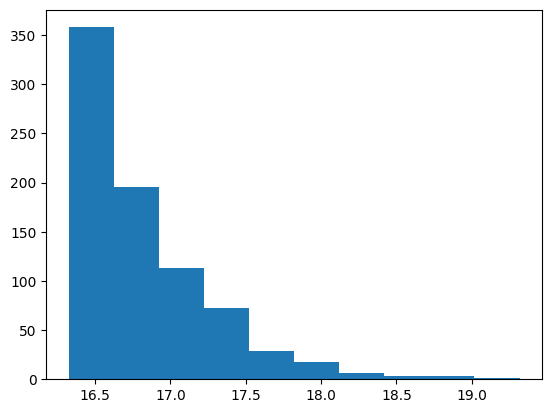

In [4]:
plt.hist(np.log1p(df["subscribers"]), bins=10)
plt.show()

Note: with this distribution, the model predicts for all bins but at lower accuracy (while equal-width binning doesn't create enough samples for all bins)

Let's now create our training and testing sets using this binning strategy (5 bins seems like enough as well).

In [5]:
import sklearn.model_selection as ms
X = df[["views", "category", "uploads", "country", "created_year"]]
Y = np.log1p(df["subscribers"])

XTrain, XTest, YTrain, YTest = ms.train_test_split(X, Y, test_size=0.3, random_state=24)

num_bins = 5

# find bins based on training data
bin_edges = np.histogram_bin_edges(YTrain, bins=num_bins, range=(Y.min(), Y.max()))

YTrain = np.digitize(YTrain, bin_edges)
YTest = np.digitize(YTest, bin_edges)

print("Train sample kinds: " + str(len(pd.unique(YTrain))))
print("Test sample kinds: " + str(len(pd.unique(YTest))))

from collections import Counter
print(Counter(YTrain))
print(Counter(YTest))

Train sample kinds: 5
Test sample kinds: 6
Counter({np.int64(1): 394, np.int64(2): 123, np.int64(3): 35, np.int64(4): 6, np.int64(5): 2})
Counter({np.int64(1): 160, np.int64(2): 63, np.int64(3): 12, np.int64(4): 3, np.int64(6): 1, np.int64(5): 1})


Let's find the best ensemble method for this data by trying many of them.
We'll try:

- Bagging
- Boosting
- Random Forests
- Extremely Random Forests


In [6]:
from sklearn.metrics import roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

n_estimators = 500

models = [DecisionTreeClassifier(max_depth=5),\
BaggingClassifier(n_estimators=n_estimators),\
RandomForestClassifier(n_estimators=n_estimators),\
ExtraTreesClassifier(n_estimators=n_estimators),\
AdaBoostClassifier(n_estimators=n_estimators, algorithm="SAMME")]

# Create a list that provides an easy way to identify each of the models later.
model_titles = ['DecisionTree', 'Bagging', 'RandomForest', 'ExtraTrees', 'AdaBoost']

# Create five empty lists for saving the computing results later
# Why is this a better way to save test result?
surv_preds, surv_probs, scores, fprs, tprs, clfs = ([] for i in range(6))

for i, model in enumerate(models):
    print("Fitting {0}".format(model_titles[i]))
    clf = model.fit(XTrain,YTrain)
    surv_preds.append(model.predict(XTest))
    surv_probs.append(model.predict_proba(XTest))
    scores.append(model.score(XTest, YTest))
    fpr, tpr, _ = roc_curve(YTest, surv_probs[i][:,1], pos_label=5) # get true and false positive rates 
    fprs.append(fpr)
    tprs.append(tpr)
    clfs.append(clf)

Fitting DecisionTree
Fitting Bagging
Fitting RandomForest
Fitting ExtraTrees
Fitting AdaBoost


In [77]:
for i, score in enumerate(scores):
    print("{0} with score {1}".format(model_titles[i], score))

DecisionTree with score 0.7875
Bagging with score 0.7333333333333333
RandomForest with score 0.75
ExtraTrees with score 0.7333333333333333
AdaBoost with score 0.6333333333333333


ROC curves for bin 5 vs rest:

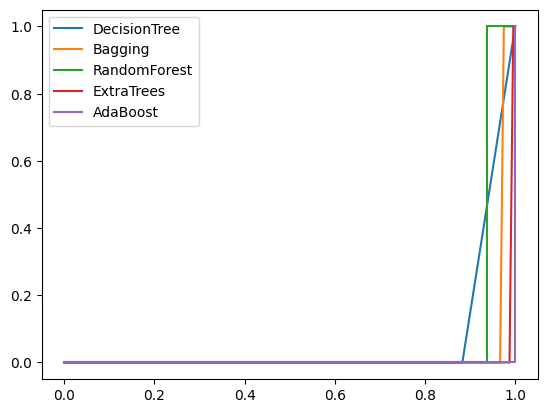

In [8]:
for i, _ in enumerate(models):
    plt.plot(fprs[i],tprs[i])

plt.legend(model_titles)
plt.show()

The decision tree produces good enough results, so let stay with that and just tune it.

In [85]:
from sklearn.metrics import mean_squared_error

param_grid = {
    'max_depth': [5, 7, 9, 10, 15, None],
    'min_samples_split': [5, 7, 10, 13, 15, 17, 19, 21],
    'min_samples_leaf': [2, 3, 4, 5, 7, 9]
}
model = DecisionTreeClassifier()

cv_tree = ms.GridSearchCV(estimator=model, param_grid=param_grid, cv=ms.KFold(), scoring="neg_mean_squared_error")
cv_tree.fit(XTrain, YTrain)

print(cv_tree.best_params_)

model = cv_tree.best_estimator_
print(model.score(XTest, YTest))

{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 7}
0.7833333333333333


In [86]:
from sklearn.tree import export_graphviz
content = export_graphviz(model, max_depth=3, feature_names=X.columns, class_names=list(map(lambda x: str(x), range(num_bins))))

import urllib
url_safe = urllib.parse.quote_plus(content)

from IPython.display import Image
from IPython.core.display import HTML 
Image(url="https://quickchart.io/graphviz?graph=" + url_safe)